In [1]:
from gensim.models import fasttext
from gensim.test.utils import datapath
import pandas as pd
from textstat.textstat import *
from nltk.sentiment import vader
from nltk import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle
import dill

## Final model assembly
The final classifier combines the knowledge from the research and experiments up to now. First, all the features will be collected, including:
- Semantic Embeddings
- Surface Features
- RNSB-Classifier-Score
- Sentiment intensity
- More features from Davidson (2017)

Two classifiers will be created, one for each semantic embedding model (pretrained facebook vectors and the finetuned model). Afterwards, to optimize the classifiers, their performance will be compared and - similar to the first classifier test - the features will be analyzed and the classifier will be optimized using hyperparameter-finetuning. Finally, the end result can be tested on new data to measure its performance across domain, viz. explicit hate.

### Loading twitter data
Same as it ever was

In [7]:
df = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv", delimiter="\t")
df_id = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg1.tsv", delimiter="\t")
df["ID"] = df_id["ID"]
df = df[df["class"] != "explicit_hate"]
df_class = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg2.tsv", delimiter="\t")
df = pd.merge(df, df_class, on="ID", how="left")
df

,post,class,ID,implicit_class,extra_implicit_class
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,399886440588247041,white_grievance,NaN
1,b.higher education is a part of european cult...,not_hate,929901925100937216,NaN,NaN
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,728678509497954304,NaN,NaN
3,is yasir qadhi a hate preacher for calling ch...,not_hate,625688620444180481,NaN,NaN
4,"rt "" : how three million germans mass murder...",not_hate,441089979322597376,NaN,NaN
...,...,...,...,...,...
20386,"Seeing prostitutes is morally wrong, but being...",implicit_hate,SAP_17154,irony,NaN
20387,I wonder how many females I raped today I spen...,implicit_hate,SAP_17179,irony,NaN
20388,Having a criminal record is more attractive to...,implicit_hate,SAP_17314,stereotypical,NaN
20389,Another advantage of being a female: getting b...,implicit_hate,SAP_17343,inferiority,NaN


### Loading vector embeddings
We will use pretrained facebook vectors and finetuned facebook vectors

In [5]:
basic_embeddings = fasttext.load_facebook_vectors(datapath("C:/Users/flohk/OneDrive/Uni/Projektseminar/data/crawl-300d-2M-subword/crawl-300d-2M-subword.bin"))
finetuned_embeddings = fasttext.FastText.load(datapath("C:/Users/flohk/OneDrive/Uni/Projektseminar/data/fasttext-finetune/model150.model")).wv

### Loading scorers from RNSB
We will use the logistic regression classifiers trained on the weaponized word corpus

In [6]:
with open("data/RNSB_classifiers/basic_classifier.pkl", "rb") as basic_file:
    basic_rnsb = pickle.load(basic_file)[0]
with open("data/RNSB_classifiers/finetuned_classifier.pkl", "rb") as finetuned_file:
    finetuned_rnsb = pickle.load(finetuned_file)[0]

## Final vectorizer
This function works the same as before, but with some additions: Two redundant features were removed and some more were added. The function takes the vector representation and the respective RNSB classifier as inputs.

In [7]:
sentiment_analyzer = vader.SentimentIntensityAnalyzer()
tokenizer = TweetTokenizer()
stop = stopwords.words("English")
caps_tokens = re.compile(r"\w+(?:'\w+)?|[^\w\s]")

def vectorize(sent, vectors, rnsb_scorer):
    
    sent = sent.replace('"', "")
    feature_vector = []
    
    # Fasttext vectors
    tokens = [token for token in tokenizer.tokenize(sent) if token not in stop]
    vecs = np.zeros(300)
    for token in tokens:
        vecs += vectors[token]
    if len(tokens) != 0:
        vecs = vecs / len(tokens)
    feature_vector += list(vecs)
    
    # Punctuation counts marks
    puncts = []
    puncts.append(sent.count("."))
    puncts.append(sent.count("..."))
    puncts.append(sent.count(","))
    puncts.append(sent.count("("))
    puncts.append(sent.count(")"))
    puncts.append(sent.count(":"))
    puncts.append(sent.count(";"))
    feature_vector += puncts
        
    # Hashtag count
    feature_vector += [sent.count("#")]
        
    # Is Retweet
    retweet = []
    if "b'RT " in sent or "bRT " in sent or " rt " in sent:
        retweet.append(1)
    else:
        retweet.append(0)
    feature_vector += retweet
        
    # ratio of words in all caps
    filterwords = [token for token in caps_tokens.findall(sent) if token.isalpha() and len(token) > 1]
    caps = [word for word in filterwords if word.isupper()]
    if len(filterwords) > 0:
        ratio = len(caps) / len(filterwords)
    else:
        ratio = 0
    feature_vector += [ratio]
    
    # hatefulness component scores
    hate_scores = []
    for token in tokens:
        hate_scores.append(rnsb_scorer.predict_proba([vectors[token]])[0,0])
    feature_vector += [max(hate_scores), sum(hate_scores)/len(hate_scores)]
    
    # Sentiment intensity analysis
    feature_vector += list(sentiment_analyzer.polarity_scores(sent).values())
    
    # Features from Davidson
    words = " ".join([token for token in tokens if token.isalpha()])
    syllables = textstat.syllable_count(words) 
    num_chars = sum(len(w) for w in words) 
    num_chars_total = len(sent)
    num_terms = len(sent.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    feature_vector += [FKRA, FRE, syllables, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms]
    
    return np.array(feature_vector)

### Benchmarking the models
Now, let's test what we have

In [10]:
def train_test_svm(X_svm, embeddings_svm, rnsb_svm, y_svm, svm_params={"kernel":"rbf", "C":100, "gamma":0.005}):
    kf = KFold(n_splits=5, shuffle=True)
    acc, prec, rec = 0, 0, 0
    svm = None
    for train_index, test_index in kf.split(X_svm):
        X_train, X_test = X_svm[train_index], X_svm[test_index]
        y_train, y_test = y[train_index], y[test_index]
        svm = SVC(**svm_params)
        svm.fit(X_train, y_train)
        test_labels = svm.predict(X_test)
        acc += accuracy_score(y_true=y_test, y_pred=test_labels)
        prec += precision_score(y_true=y_test, y_pred=test_labels, zero_division = 0)
        rec += recall_score(y_true=y_test, y_pred=test_labels)
    return svm, acc/5, prec/5, rec/5

In [ ]:
y = np.array(df['class'] == "implicit_hate")
X_basic = StandardScaler().fit_transform(np.array([vectorize(tweet, basic_embeddings, basic_rnsb) for tweet in df["post"]])) 
X_finetuned = StandardScaler().fit_transform(np.array([vectorize(tweet, finetuned_embeddings, finetuned_rnsb) for tweet in df["post"]]))  

basic_svm, basic_acc, basic_prec, basic_rec = train_test_svm(X_basic, basic_embeddings, basic_rnsb, y)
print("Basic embeddings: accuracy", basic_acc, "precision", basic_prec, "recall", basic_rec)
finetuned_svm, finetuned_acc, finetuned_prec, finetuned_rec = train_test_svm(X_finetuned, finetuned_embeddings, finetuned_rnsb, y)
print("Finetuned embeddings: accuracy", finetuned_acc, "precision", finetuned_prec, "recall", finetuned_rec)

In [181]:
def f15 (precc, recc):
    return 4.375 * ((precc * recc) / ((3.375 * precc) + recc))

In [128]:
print("basic:", f15(basic_prec, basic_rec), "finetuned:", f15(finetuned_prec, finetuned_rec))

basic: 0.5677792888634975 finetuned: 0.5549277370867924


This data suggests two things:
1. Because we still value F1.5 over accuracy, it seems like the finetuned word embeddings perform more weakly and are thus not useful for our purposes
2. The scores have not significanty improved since the previous iteration of the model. Since most of the added features were taken from the Davidson (2017) classifier where they have proven to be very useful, this may imply that the problem of detecting implicit hate speech might be categorically different from explicit hate speech. Otherwise, we would expect the same features to have positive impact on performance

### Feature analysis
Just to make sure, we will perform the same feature analysis from before to see if there were any changes. We will train the same Decision tree as before and measure its featureimportances.

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, r_regression
from scipy.stats import variation
from matplotlib import pyplot

In [134]:
feature_names = ["embedding " + str(n) for n in range(300)] + ["num of " + p for p in [".", "...", ",", "(", ")", ":", ";", "#"]] + ["is retweet", "CAPS ratio", "hatefulness max word", "hatefulness average"] + ["sentiment " + p for p in ["negative", "neutral", "positive", "compound"]] + ["FKRA", "FRE", "syllables", "num_chars", "num_chars_total", "num_terms", "num_words", "num_unique_terms"]   

In [144]:
decision_tree = DecisionTreeClassifier(min_samples_leaf= 10, min_samples_split= 24)
decision_tree.fit(X_basic, y)

DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=24)

In [145]:
tree_importances = pd.DataFrame([[feature_names[f], np.sort(decision_tree.feature_importances_)[i]] for i, f in enumerate(np.argsort(decision_tree.feature_importances_))], columns = ["feature", "importance"])
with pd.option_context('display.min_rows', 324, 'display.max_rows', 324):
    display(tree_importances)

,feature,importance
0,embedding 183,0.000000
1,num of .,0.000000
2,embedding 168,0.000000
3,embedding 119,0.000000
4,embedding 110,0.000000
5,embedding 95,0.000000
6,embedding 93,0.000000
7,embedding 207,0.000000
8,embedding 210,0.000000
9,embedding 218,0.000000


It seems that - at least for the decision tree classifier - some of the new features are actually important. The `num_chars_total` and `hatefulness max word` in particular have an importance of over 1%. 

We can also compare relative variance

In [153]:
analysis_features = np.array([vectorize(tweet, basic_embeddings, basic_rnsb) for tweet in df["post"]])
feature_variances = pd.DataFrame([[feature_names[f], np.sort(np.abs(variation(analysis_features, axis=0)))[i]] for i, f in enumerate(np.argsort(np.abs(variation(analysis_features, axis=0))))], columns = ["feature", "variance"])
with pd.option_context('display.min_rows', 324, 'display.max_rows', 324):
    display(feature_variances)

,feature,variance
0,embedding 95,0.177056
1,sentiment neutral,0.241996
2,hatefulness max word,0.269543
3,hatefulness average,0.362537
4,embedding 45,0.397284
5,num_chars_total,0.462009
6,num_unique_terms,0.467181
7,embedding 119,0.472719
8,num_terms,0.479595
9,num_words,0.490526


The coefficient of variation is highest in the embedding vectors. Most non-semantic features don't have a lot of variation. Especially the hatefulness ratings very only slighty. This is however interesting because the `hatefulness max word` score is quite important to the Decision tree.  

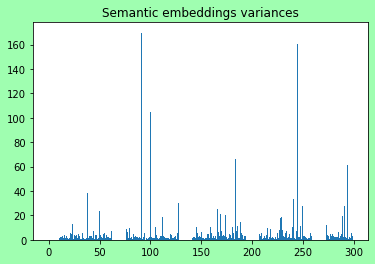

In [159]:
pyplot.figure(facecolor="xkcd:mint")
pyplot.bar(range(300), np.abs(variation(analysis_features, axis=0))[:300])
pyplot.title("Semantic embeddings variances")
pyplot.show()

In [168]:
k_best = SelectKBest(r_regression, k=250)
k_best.fit(analysis_features, y)
k_best_removed = k_best.get_support()
_ = [print(feature_names[i]) for i in range(312) if k_best_removed[i] == False]

embedding 4
embedding 6
embedding 7
embedding 10
embedding 11
embedding 16
embedding 20
embedding 22
embedding 23
embedding 30
embedding 38
embedding 45
embedding 51
embedding 52
embedding 60
embedding 61
embedding 63
embedding 64
embedding 69
embedding 70
embedding 75
embedding 77
embedding 78
embedding 81
embedding 82
embedding 86
embedding 88
embedding 114
embedding 119
embedding 121
embedding 128
embedding 135
embedding 136
embedding 142
embedding 144
embedding 151
embedding 155
embedding 157
embedding 162
embedding 163
embedding 164
embedding 165
embedding 166
embedding 176
embedding 192
embedding 194
embedding 202
embedding 206
embedding 210
embedding 213
embedding 214
embedding 220
embedding 224
embedding 227
embedding 231
embedding 236
embedding 240
embedding 241
embedding 242
embedding 246
embedding 254
embedding 255
embedding 256
embedding 261
embedding 266
embedding 272
embedding 275
embedding 276
embedding 282
embedding 294
embedding 296
embedding 297
embedding 298


When analyzing the feature space using Pearson correlation, it seems like the additional features are at least somewhat useful.

With everything taken into consideration, we won't strip these new features from the classifier. Despite not yielding much improvement to the classifier's scores, they seem to be useful according to Decision tree importance and feature analysis. So, no adjustment to the feature space is neccessary.

### Finetuning the SVM
Finally, we can perform one last grid-search to finetune the hyperparameters. Since it is unlikely that a lot has changed since the last iteration, we can limit the search to a small range so that we don't need to scan a huge area which will speed up the grid search considerably.

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [172]:
f15 = make_scorer(fbeta_score, beta=1.5)
grid_svm = {"C": [50, 75, 100, 250, 500],
            "gamma": [0.01, 0.0075, 0.005, 0.001]}
searcher_svm = GridSearchCV(SVC(kernel="rbf"), grid_svm, cv = 3, n_jobs = -1, refit = True, scoring = f15, verbose = 3)
searcher_svm.fit(X_basic, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [50, 75, 100, 250, 500],
                         'gamma': [0.01, 0.0075, 0.005, 0.001]},
             scoring=make_scorer(fbeta_score, beta=1.5), verbose=3)

In [173]:
searcher_svm.best_score_

0.4253184115251834

In [174]:
searcher_svm.best_params_

{'C': 250, 'gamma': 0.001}

In [ ]:
final_svm, f_acc, f_prec, f_rec = train_test_svm(X_basic, basic_embeddings, basic_rnsb, y, svm_params={'C':250, 'gamma':0.001, 'kernel':"rbf"})

In [180]:
print("Hyperparameter finetuning: accuracy", f_acc, "precision", f_prec, "recall", f_rec)

Hyperparameter finetuning: accuracy 0.722230599894362 precision 0.60524438314769 recall 0.5818535835692188


In [182]:
print(f15(f_prec, f_rec))

0.587039235603636


By using an f1.5 scorer, the classifier lost a bit of accuracy and precision, however that evened out the scores. Since in the end, both precision and recall are more or less equally important for this kind of task, having the scores more aligned and equal seems like a positive. Having these parameters finalized, the classifier is built. We can now train an SVM over the whole dataset and that will be the final "product".

In [ ]:
implicit_hate_classifier = SVC(kernel="rbf", C=250, gamma =0.001)
implicit_hate_classifier.fit(X_basic, y)
with open("implicit_hate_classifier/implicit_hate_classifier.pkl", "wb") as file:
    pickle.dump(implicit_hate_classifier, file)
scaler = StandardScaler().fit(np.array([vectorize(tweet, basic_embeddings, basic_rnsb) for tweet in df["post"]])) 
with open("implicit_hate_classifier/scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)
with open("implicit_hate_classifier/vectorize.pkl", "wb") as file:
    pickle.dump(vectorize, file)

In [6]:
with open("implicit_hate_classifier/vectorize.pkl", "wb") as file:
    dill.dump(vectorize, file)

In [2]:
with open("implicit_hate_classifier/implicit_hate_classifier.pkl", "rb") as file:
    implicit_hate_classifier = pickle.load(file)

## Testing the classifier out of domain
Finally, we will test how well the classifier performs on other data. We will look at two cases:
1. Another dataset which considers mainly implicit hate
2. General hatefulness classification

Of course, it only makes sense to perform similar data. Because our classifier was trained on social media posts (aka short texts), we should look toward other social media corpora for comparison.

#### I feel offended, don't be abusive
Sadly, after requesting access to the data from https://github.com/tommasoc80/AbuseEval, I have yet to receive a reply. So I cannot test on this dataset. 

#### Automatic Hate speech detection and the problem of offensive language
The other data comes from https://github.com/t-davidson/hate-speech-and-offensive-language. This dataset contains tweets that are classified to be either hateful, abusive or neither and it mostly concerns explicit hatefulness. Since the data is multiclass which our model can't deal with, we remove the class with offensive tweets. In order to test this data, there are two possibilities:
1. Use our current final classifier to predict the class for this data
2. Retrain the classifier on this data and see how well it performs

We will only perform the first option because it is more relevant to the research question (and also because we implemented a lot of the features from this paper into our model, so retraining on this data would really only be interesting regarding the performance difference from an SVM used here to a logistic regression classifier used there).

In [3]:
dfdavid = pd.read_csv("data/davidson/labeled_data.csv")
dfdavid = dfdavid[dfdavid["class"] != 1]
dfdavid["class"] = np.asarray(dfdavid["class"] == 0, dtype=int)
# dfdavid.iloc[np.asarray(dfdavid["hate_speech"] == 3)]
dfdavid

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
40,40,3,0,1,2,0,""" momma said no pussy cats inside my doghouse """
63,63,3,0,0,3,0,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,66,3,0,1,2,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,67,3,0,1,2,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."
...,...,...,...,...,...,...,...
24767,25280,3,0,1,2,0,"you know what they say, the early bird gets th..."
24776,25289,3,3,0,0,1,you're all niggers
24777,25290,3,2,1,0,1,you're such a retard i hope you get type 2 dia...
24779,25292,3,0,1,2,0,"you've gone and broke the wrong heart baby, an..."


In [4]:
from collections import Counter
Counter(dfdavid["class"])

Counter({0: 4163, 1: 1430})

In [8]:
X_david = StandardScaler().fit_transform(np.array([vectorize(tweet, basic_embeddings, basic_rnsb) for tweet in dfdavid["tweet"]])) 
y_david = np.array(dfdavid['class'])

In [9]:
y_david_pred = implicit_hate_classifier.predict(X_david)

In [10]:
acc_david = accuracy_score(y_true=y_david, y_pred=y_david_pred)
prec_david = precision_score(y_true=y_david, y_pred=y_david_pred, zero_division = 0)
rec_david = recall_score(y_true=y_david, y_pred=y_david_pred)
print("accuracy:", acc_david, "precision:", prec_david, "recall:", rec_david)

accuracy: 0.49347398533881637 precision: 0.26671100764881944 recall: 0.5608391608391609


Accuracy and recall don't seem to bad, but the precision is terrible. Let's compare to a random baseline.

In [12]:
y_david_random = np.asarray(np.random.rand(5593) >= 0.5, dtype=int)
acc_david_r = accuracy_score(y_true=y_david, y_pred=y_david_random)
prec_david_r = precision_score(y_true=y_david, y_pred=y_david_random, zero_division = 0)
rec_david_r = recall_score(y_true=y_david, y_pred=y_david_random)
print("accuracy:", acc_david_r, "precision:", prec_david_r, "recall:", rec_david_r)

accuracy: 0.507777579116753 precision: 0.25901639344262295 recall: 0.4972027972027972


We can see that it is hardly better than random chance. Thus, we can draw the tentative conclusion that the task of implicit hate speech classification is sufficiently detached from explicit (or general) hate speech classification.